<a id="timeseries"></a>
# Time series modeling


_"It’s Difficult to Make Predictions, Especially About the Future"_

                                - Niels Bohr (or Piet Hein)
                                
_"I have seen the future and it is very much like the present, only longer."_

                                - Kehlog Albran, The Profit


Or: What if regression happens in time?



It is a common case - often offering serious business advantages -  to use a time series of datapoints measured in certain intervals in time to predict the (some) next values of a given target value. (weather, operating parameters, traffic, exchange rates ...)


## Basic observations / definitions  

**Sequential Data:**

The order of the data matters, but the time stamp is irrelevant or it doesn’t matter. (Example: DNA sequence. The concept of time is irrelevant, so the order is not temporal.)

**Temporal Sequence:**

In addition to the order of data, the time stamp also matters. (Example: Data collected from customers’ shopping behaviour, considering their transaction time stamp as the temporal dimension.)

**Time Series:**

The data is in order, with a fixed time-difference between occurrence of successive data points. (Example: Time series of the temperature of a surface being recorded every 120 seconds.) 

([source](https://www.quora.com/What-is-the-difference-between-time-series-and-sequential-data))


In the special case when the temporal signals have also some spatial aspect, think for example speed measurements of cars at different locations we talk about "spatio-temporal" data. This type of problem lies out of scope for this course, but a good overview of methods can be found [here](https://www.mdpi.com/2220-9964/4/4/2306/pdf) and [here](https://arxiv.org/pdf/1711.04710).


**There are obvious differences from the datasets we've been working with prior:**

- The sequential position of the datapoints (commonly represented as datarows) is of paramount importance (we are in trouble if we would like to draw a random sample...)
- We should not have an i.i.d. assumtion, so we should be well advised to think, that there is a relationship between successive datapoints
- It is always suspicious wether the [Markov assumption]of conditional independence (https://en.wikipedia.org/wiki/Markov_property) holds in case of the data. For random walks it does, but it it is rarely the case in practice. (We can try to figure out which "order" of Markov property is present, but it is not a clear cut line. (Does the weather of tomorrow depend on today? And yesterday? And the year before? And hundered?...)


## Main learning scenarios

### Prediction basis

- One variable (univariate time series):

We have at our disposal a sequence of measurements from one variable, our goal is to predict the (some) next measurement point(s). (If we look closely, we can phrase it as a two or more variable regression problem the independent variable(s) is(are) time steps into the past and the dependen variable is the step into the future that needs to be predicted). 
In this case we base our prediction on the variable itself about it's next state, this presupposes that the "history" of the variable, that is some prior measurements of it have predictive power regarding it's future behavior. (Markov n?...)

- We have more variables to work with (Multivariate timeseries)

We have parallel measurements of multiple variables, and we have to predict the future state of one of them. (It can well be possible, that we don't have measured values for all variables in all timesteps)


### Prediction horizon

- Single step forecasting
- Multi step forecasting

#### In this later case we have different strategies what we can try:

_1. Direct Multi-step Forecast Strategy_

In the case of predicting the temperature for the next two days, we would develop a model for predicting the temperature on day 1 and a separate model for predicting the temperature on day 2.

$prediction(t+1) = model1(obs(t), obs(t-1), ..., obs(t-n))$
$prediction(t+2) = model2(obs(t+1), obs(t), ..., obs(t-n))$

_2. Recursive Multi-step Forecast_

The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.
In the case of predicting the temperature for the next two days, we would develop a one-step forecasting model. This model would then be used to predict day 1, then this prediction would be used as an observation input in order to predict day 2.


$prediction(t+1) = model(obs(t), obs(t-1), ..., obs(t-n))$
$prediction(t+2) = model(prediction(t+1), obs(t), ..., obs(t-n))$


_3. Direct-Recursive Hybrid Strategies_

The direct and recursive strategies can be combined to offer the benefits of both methods.
For example, a separate model can be constructed for each time step to be predicted, but each model may use the predictions made by models at prior time steps as input values.



$prediction(t+1) = model1(obs(t), obs(t-1), ..., obs(t-n))$
$prediction(t+2) = model2(prediction(t+1), obs(t), ..., obs(t-n))$


_4. Multiple Output Strategy_

The multiple output strategy involves developing one model that is capable of predicting the entire forecast sequence in a one-shot manner.

$prediction(t+1), prediction(t+2) = model(obs(t), obs(t-1), ..., obs(t-n))$

[source](https://machinelearningmastery.com/multi-step-time-series-forecasting/)




### Time series classification

We have a set of fixed or variable length time series plus class labels corresponding to them, based on some features or descriptors (typically of the whole) time series we would like to build a classifier that assigns class labels to future series. Time series classification is not in focus at this course, but we will talk about it a bit later.

### Categorical time series "regression"

Regression on sequential data is also possible if the data is comprised of sequence of categorical measurements - eg. elements from a vocabulary, like DNA.

This case is in a sense a something in-between sequence categorization (since we predict one from several labels) and regression (since we can represent the categories with integers, then we have and integer sequence to integer prediction problem).

A good overview of an elegant method for generalizing linear models to categorical data can be found [here](https://projecteuclid.org/download/pdf_1/euclid.ss/1076102425).

We will concern us deeply with sequential data models in case of language.

## An example: predicting the number of air passangers 

For more technical details, see the notebook "Time series wrangling with Pandas".

**Data source: [Monthly Airline Passenger Numbers (in thousands) 1949-1960](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html)**

(Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. 
Third Edition. Holden-Day. Series G.)


Direct  link [here](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv)


In [1]:
!wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/AirPassengers.csv

--2020-10-09 08:54:09--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/AirPassengers.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘AirPassengers.csv’

AirPassengers.csv       [ <=>                ]   1.71K  --.-KB/s    in 0s      

2020-10-09 08:54:10 (26.3 MB/s) - ‘AirPassengers.csv’ saved [1746]



In [2]:
import pandas as pd
df = pd.read_csv("AirPassengers.csv",header=0)

## Description of the dataset

In [3]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


**It is worth mentioning, that `.describe()` was designed for i.i.d. data and not timeseries, so many times visualization helps here much more.**

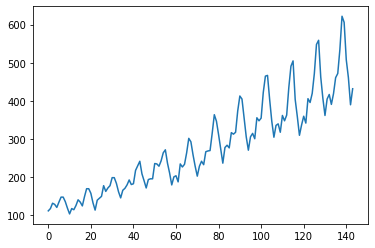

In [5]:
import matplotlib.pyplot as plt
plot = df["#Passengers"].plot()
plt.show()

### What do we see here?

- Trending movement
- Recurring, periodic patterns
    - Can we guess what the period represents?
- And some added variance (noise??)

### How can we describe a time series?

#### Trend - [Stationarity of a process](https://en.wikipedia.org/wiki/Stationary_process)
"... stationary process (a.k.a. a strict/strictly stationary process or strong/strongly stationary process) is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time." 
- If there is a "disturbance" or change from the original path, the time series will "return" to it
- Most common change in non-stationarity is a change in mean e.g. as there is a trend over time
- A number of traditional time series techniques assume a stationary process

In general the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) serves the purpose to conclude wether a process is stationary. 

$$y_{t}=\rho y_{t-1}+u_{t}$$

where $ y_{t}$ is the variable of interest, $t$ is the time index, $\rho$  is a coefficient, and $u_{t}$ is the error term. A unit root is present if $\rho =1$. The model would be non-stationary in this case.

The regression model can be written as:

$${\displaystyle \Delta y_{t}=(\rho -1)y_{t-1}+u_{t}=\delta y_{t-1}+u_{t}\,}$$

where $\Delta$  is the first difference operator. This model can be estimated and testing for a unit root is equivalent to testing $\delta =0$ (where $\delta \equiv \rho -1$). 

If $p$ probability valuie is below the 5% confidence treshold, we are inclined to accept the process as stationary. Here in this case - without causing too big of a surprise - we conclude non stationarity.


In [6]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df["#Passengers"].values)

print('p-value: %f' % result[1])

print("Should be under 0.05")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


p-value: 0.991880
Should be under 0.05


#### Visual illustration for trend

Seaborn plays absolutely nicely with coloured boxplots, we could not resist :-)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


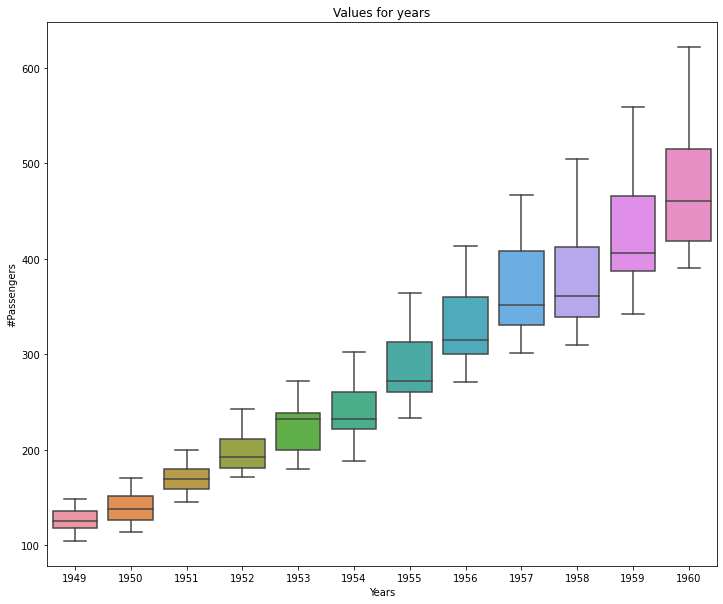

In [7]:
import seaborn as sns
reindexed_df = df.copy()
reindexed_df.Month = reindexed_df.Month.astype('datetime64[ns]')
reindexed_df = reindexed_df.set_index("Month")

plt.close()
#It is sometimes good to make sure the canvas prior is rendered and plot is closed.

fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(reindexed_df.index.year, reindexed_df["#Passengers"], ax=ax)#, width=20)
plt.title("Values for years")
plt.xlabel("Years")
plt.show()

#### Periodicity (Seasonality)

It is also obvious, that there is preiodicity in the data, so we should visualize this in periodic, "overlapped" boxplots, to get a sense of it.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


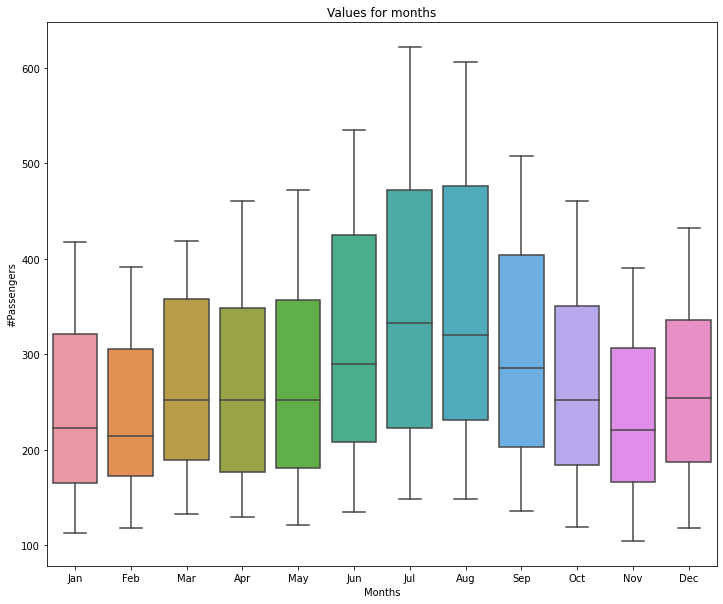

In [8]:
fig, ax = plt.subplots(figsize=(12,10))

sns.boxplot(reindexed_df.index.strftime("%b"), reindexed_df["#Passengers"], ax=ax)#, width=20)
#to make it more readable, we use the month's name instead of month number, see: 
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Period.strftime.html
plt.title("Values for months")
plt.xlabel("Months")
plt.show()

From this we can draw the unusual conclusion, that since the early days of commercial flight people tend to go on holidays in the summer. :-)

#### Decomposition
[Source](https://en.wikipedia.org/wiki/Decomposition_of_time_series)

Based on the steps above, we could try to decompose the time series into trend, periodic signal and "residual noise" components. This is an idealistic approach, since it presupposes that everything apart from a trend and a periodic signal is akin to noise and does not take into account that higher order or more complex patters / influences can be present. None the less this is a standard baseline approach that is well worth trying.

- $T_{t}$, the trend component at time t, which reflects the long-term progression of the series (secular variation). A trend exists when there is a persistent increasing or decreasing direction in the data. The trend component does not have to be linear.
- $S_{t}$, the seasonal component at time t, reflecting seasonality (seasonal variation). A seasonal pattern exists when a time series is influenced by seasonal factors. Seasonality occurs over a fixed and known period (e.g., the quarter of the year, the month, or day of the week).
- $I_t$, the irregular component (or "noise") at time t, which describes random, irregular influences. It represents the residuals or remainder of the time series after the other components have been removed.

Hence a time series using an additive model can be thought of as

${\displaystyle y_{t}=T_{t}+S_{t}+I_{t},}$

whereas a multiplicative model would be

${\displaystyle y_{t}=T_{t}\times S_{t}\times I_{t}.\,}$ 

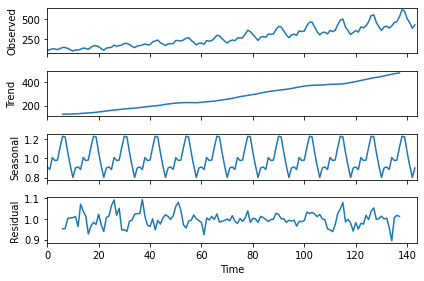

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.close()
#from statsmodels.tsa.seasonal 
analysis = seasonal_decompose(df["#Passengers"].values,model="multiplicative", freq=12)

analysis.plot()
plt.show()

We can see the original series at the top, a quite clear trend as well as a complex periodic signal.
It is always worth paying attention to the residual plot, since it can happen, that there is still some pattern uncaptured by the decomposition (as we can suspect in the beginning and the end of the timeseries), which can give hints towards modeling.

The other aspect worth mentioning is the notes of the statsmodels documentation itself:

The seasonal component is first removed by applying a convolution filter to the data. The average of this smoothed series for each period is the returned seasonal component."

<img src="https://i.stack.imgur.com/2Wze5.png" height=500 width=500>

In an additive model the period components are added together, in a multiplicative multiplied, so their effect is "cumulative".

We deliberately choose the multiplicative model, but that was based on intuition that we arrived at by looking at the data.

#### What normalizations and transformations can we use?

More on normalizing transformations [here](https://people.duke.edu/~rnau/411diff.htm).

##### Trend
One easy and frequently utilized approach to "detrending" the time series is taking it's first differential.

More on types of trend and their removal [here](https://machinelearningmastery.com/time-series-trends-in-python/).



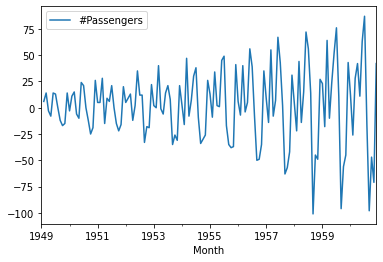

In [10]:
reindexed_df.diff(1).plot()
plt.show()

As we can see, subtracting $X_{t-1}$ from $X_t$ has the nice effect of "removing" trend. Removing in the sense of normalization. And that is exactly the other widespread usage of `diff`, to normalize a time series into a more easily handleable range even in case of large trends. 

##### Seasonality

If we take a bigger step, it is also possible, to counteract the seasonality effects. Good question is, how we know the proper period for it. None the less, `diff` can be a way - albeit pretty crude.

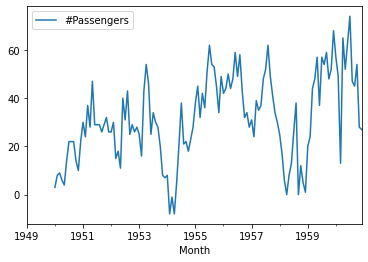

In [11]:
reindexed_df.diff(12).plot()
plt.show()

##### Fractional differencing

It is worth mentioning, that there has been work done for extending the differencing methods to non-integer fractions to the observation period, such as demonstrated in [this paper](https://wwwf.imperial.ac.uk/~ejm/M3S8/Problems/hosking81.pdf). The argument is, that long-term dependencies can be captured more easily with this method.

The idea found some use quite recently based on this [book](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089) in the financial domain. (some code examples [here](https://github.com/philipperemy/fractional-differentiation-time-series).) 

###### Multiplicative effects

For multiplicative effects we could try `log` transformation.

More on nice properties of logarithmic transformations [here](http://people.duke.edu/~rnau/411log.htm).

(Alternatively, twice differencing could be tried...)

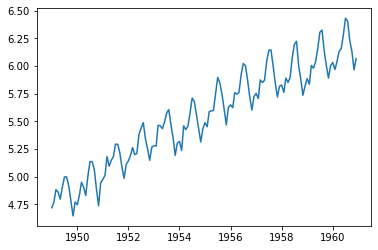

In [12]:
import numpy as np
plt.plot(reindexed_df.index.values,np.log(reindexed_df["#Passengers"]))
plt.show()

##### What remains?

This is absolutely not best practice, but we can see what remains if we chain together the transformations.

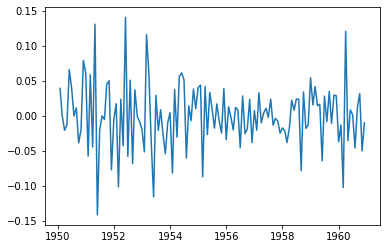

In [13]:
logs = pd.Series(np.log(reindexed_df["#Passengers"])).diff(1).diff(12)
plt.plot(reindexed_df.index.values, logs)
plt.show()

##### Takeaways

Please observe, that these were all reversible transformations, but none the less radically altered our outlook just because they meant different **representations** of the data.

More on some transformations and their usage see [here](https://people.duke.edu/~rnau/whatuse.htm)

It is debatable, if such transformations help in modeling, but that also strongly depends on the model. For a more detailed discussion see this [paper](https://research.cs.aalto.fi/aml/Publications/Publication173.pdf).

#### [Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) and [partial autocorrelation](https://en.wikipedia.org/wiki/Partial_autocorrelation_function)

"Back to the Markov question"

We should take into account all the above insights at the modelling stage, but it is also important to think about the temporal dependency inside the process that unfolds in time. (We can think of it as "how big is the memory capacity of the process".) 
The baseline - and understandably naive - approach to analysing this is the modeling of autocorrelations. This is just the basic data science method of observing correlations - though in time, between different points "back" in time, and the "present" value in a "sliding window".

While [ACF](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html) (autocorrelation function) observes correlations "naively" with some amount of time-points, [PACF](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.pacf.html) (partial autocorrelatoin function) tries to control for the fact, that the effect of points in time travel through the series, so if there is a very influential effect in an early point in time, it's effect would be influencing all next time points, making them look also influential. In PACF this is controlled for.

**Autocorrelation** for a continous time signal:
Given a signal $f(t)$, the continuous autocorrelation  $R_{ff}(\tau )$ is most often defined as the continuous cross-correlation integral of $f(t)$ with itself, at lag $\tau$ 

$${\displaystyle R_{ff}(\tau )=\int _{-\infty }^{\infty }f(t+\tau ){\overline {f(t)}}\,{\rm {d}}t=\int _{-\infty }^{\infty }f(t){\overline {f(t-\tau )}}\,{\rm {d}}t} $$



**Auto-correlation** of discrete-time signal:
The discrete autocorrelation $R$ at lag $\ell$  for a discrete-time signal $y(n)$ is

$${\displaystyle R_{yy}(\ell )=\sum _{n\in Z}y(n)\,{\overline {y(n-\ell )}}} {\displaystyle R_{yy}(\ell )=\sum _{n\in Z}y(n)\,{\overline {y(n-\ell )}}}$$



**Partial auto correlation:**
Given a time series $ z_{t}$, the partial autocorrelation of lag k, denoted $\alpha(k)$, is the autocorrelation between $z_{t}$ and $z_{{t+k}}$ with the linear dependence of $z_{t}$ on $z_{{t+1}}$ through $z_{t+k-1}$ removed; equivalently, it is the autocorrelation between $z_{t+1}$ and $z_{t+k+1}$ that is not accounted for by lags 1 to k , inclusive.

${\displaystyle \alpha (1)=\operatorname {corr} (z_{2},z_{1}),{\text{ for }}k=1,}$
${\displaystyle \alpha (k)=\operatorname {corr} (z_{t+k+1}-P_{t,k}(z_{t+k+1}),\,z_{t+1}-P_{t,k}(z_{t+1})),{\text{ for }}k\geq 2,}$

where $P_{{t,k}}(x)$ is surjective operator of orthogonal projection of $x$ onto the linear subspace of Hilbert space spanned by ${\displaystyle x_{t+1},\dots ,x_{t+k}}$.

 

 

 





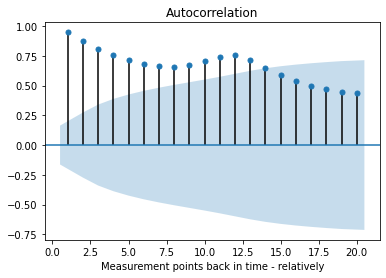

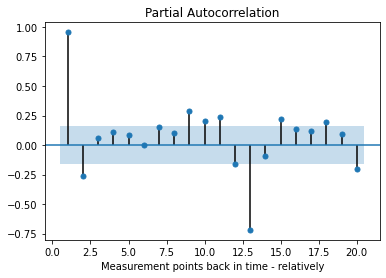

---


In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.close()
plot_acf(df["#Passengers"].values, lags=20, zero=False)
plt.xlabel("Measurement points back in time - relatively")
plt.show()
plot_pacf(df["#Passengers"].values, lags=20, zero=False)
plt.xlabel("Measurement points back in time - relatively")
plt.show()
print("---")

The blue area represents confidence intervals, so the real signals are the far outliers. 

It is interesting to see, that the "year before" mesurement is strongly influential - this implies at least a year of "memory" in the system, and much of the effects visible in ACF just "pass through" from former. It is well worth using ACF!

## Modeling demonstration

### First try: the linear way

It is easy and obvious to set up a linear model for the data. The only thing worth mentioning is that since we only have one measurement y (univariate), the x coordinate here is time itself, so we model how the data changes with respect to time.

#### Detour: Measuring goodness - No shuffling, please!

As always we should seprate training and test data, with the help of `train_test_split` from Scikit.

It is of paramount importance though, that we disable the random shuffling of the dataset, which is _on by default_ so that we preserve the temporal patterns! 

**Validation of time series models is a bit trickier than in the normal regression case.**


For a good summary see:
[How To Backtest Machine Learning Models for Time Series Forecasting](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

1. Train-Test split that respect temporal order of observations.
2. Multiple Train-Test splits that respect temporal order of observations.
3. Walk-Forward Validation where a model may be updated each time step new data is received.

As well as [this](https://blog.insightdatascience.com/whats-wrong-with-my-time-series-model-validation-without-a-hold-out-set-94151d38cf5b) in depth blogpost, together with [this](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.30.6748) and [this](https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html) papers.

It is also worth noting, that some alternative error measures can also be applied in time series case, like [MASE](http://eva.fcea.edu.uy/pluginfile.php/109034/mod_resource/content/0/2006_Hyndman_Predicc.pdf) implemented [here](https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py).

#### Detour 2: Measuring in what?

The measurement of accuracy in time series predictions is in itself a complex subject. The different opinions and measurement models should match the exact business context and support the actions we would like to take.

A short summary well worth reading through in this topic: [Naughty APEs (Absolute Percentage Error) and the quest for the holy grail](http://forecasting.svetunkov.ru/en/2017/07/29/naughty-apes-and-the-quest-for-the-holy-grail/).



In [15]:
# !!! shuffle = False !!!
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.1, shuffle=False)

... and we train a linear model

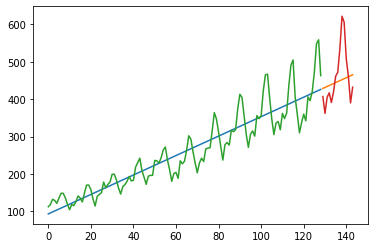

In [16]:
from sklearn import linear_model
lin_model= linear_model.LinearRegression()
lin_model.fit(train_data.index.astype("int64").values.reshape(-1, 1),train_data["#Passengers"].values)#

train_fit = lin_model.predict(train_data.index.astype("int64").values.reshape(-1, 1))
train_fit = pd.Series(train_fit)
train_fit.index =train_data.index

prediction = lin_model.predict(test_data.index.astype("int64").values.reshape(-1, 1))
prediction = pd.Series(prediction)
prediction.index =test_data.index


plt.plot(train_fit)
plt.plot(prediction)

plt.plot(train_data["#Passengers"])

plt.plot(test_data["#Passengers"])

plt.show()

Witrh no surprise we observe, that this captured the main trend in the series, which is really imprecise, but can none the less be informative.

### Exponential smoothing

If we believe, that the causal effects in timeseries "flow along" smoothly, it is all the more logical to assume, that the prior signals are directly affecting the present ones, albeit the "far past" is having an exponentially smaller effect than the recent.

The technique of **exponential smoothing** is based exactly on this assumption.

<img src="https://cdn-images-1.medium.com/max/1400/1*rWt9KIT0jVJzlIJ2sI8-Dg.png" width=55%>

AWhere 0≤ α ≤1 is a smoothing parameter.

More details [here](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1). (For more simple smoothing techniques, see the same source...)

"The weights decrease rate is controlled by the smoothing parameter α. If α is large (i.e., close to 1), more weight is given to the more recent observations. There are 2 extreme cases:

α=0: the forecasts of all future values are equal to the average (or “mean”) of the historical data, which is called **Average method**.

α=1: simply set all forecasts to be the value of the last observation, which is called **Naive method** in statistics."

[Source](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1)

As we can see, we are also trying to estimate some kind of "memory capacity".

In [17]:
from statsmodels.tsa.api import ExponentialSmoothing


history = [x for x in list(train_data["#Passengers"].values.astype("float"))]
predictions = list()

print("Prediction with ES method:\n")

# We iterate through the test set step by step
# Yes, test set. This can be undestood as an on-line learning scenario, for each datapoint 
for t in range(len(list(test_data["#Passengers"].values.astype("float")))):
    
    # Model inicialization
    model = ExponentialSmoothing(history)
    
    # Worth noting,that with seasonality, trend and additivity parameters well chosen
    # - since Statsmodels is quite clever - 
    # we could reach MUCH better results. This is only  anaive demonstration
    
    model_fit = model.fit(use_boxcox=True)
    # Predicting one step ahead
    output = model_fit.forecast(1)
    # colecting predictions
    yhat = output[0]
    predictions.append(yhat)
    
    #doing one step in time
    obs = list(test_data["#Passengers"].values.astype("float"))[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))


Prediction with ES method:

predicted=463.000000, expected=407.000000
predicted=407.000000, expected=362.000000
predicted=362.000000, expected=405.000000
predicted=405.000000, expected=417.000000
predicted=417.000000, expected=391.000000
predicted=391.000000, expected=419.000000
predicted=419.000000, expected=461.000000
predicted=461.000000, expected=472.000000
predicted=472.000000, expected=535.000000
predicted=535.000000, expected=622.000000
predicted=622.000000, expected=606.000000
predicted=606.000000, expected=508.000000
predicted=508.000000, expected=461.000000
predicted=461.000000, expected=390.000000
predicted=390.000000, expected=432.000000



Mean abs error: 45.79999999999997
Explained variance: 0.5196648416088108


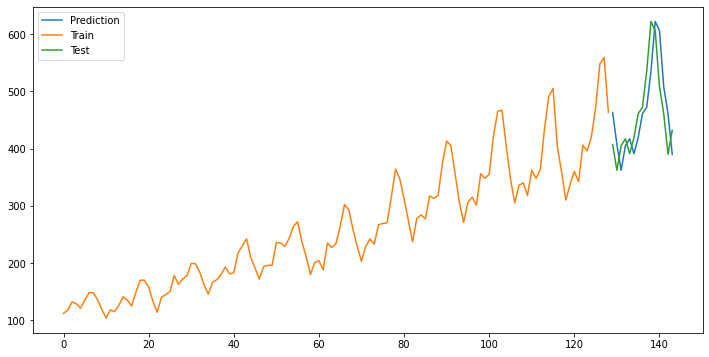

In [18]:
from sklearn.metrics import mean_absolute_error, explained_variance_score
    
errors = np.array(test_data["#Passengers"].values)-np.array(predictions)

print()
print("Mean abs error:",mean_absolute_error(test_data["#Passengers"].values,predictions))
print("Explained variance:",explained_variance_score(test_data["#Passengers"].values,predictions))

predictions = pd.Series(predictions)
predictions.index =test_data.index    

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(predictions, label="Prediction")

plt.plot(train_data["#Passengers"], label="Train")

plt.plot(test_data["#Passengers"], label="Test")
plt.legend()
plt.show()

### ARIMA

[Autoregressive Integrated Moving Average](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) is a traditional modeling technique, which - as it's name implies - uses autoregression and a moving average component to model the "present moment" with respect to prior moments with an autoregressive and some smoothed moving average (different smoothing techniques can be used, see more [here](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average), for more detailed elaboration see [here](https://medium.com/@abhinav.mahapatra10/beginners-ml-basics-exponentially-weighted-moving-average-8ce3e75768f6)) - these are the _AR_ and _MA_ in the names.
The _integral_ part (the I) comes from the fact that ARMA is extended, and is applied to the differential of the time series, thus representing "trend". I=1 is the first differential, it represents linear trend.

It is important to note, that ARIMA is parametrized by hand, in our case we used `ARIMA(..., order=(5,1,0)` which means 5 autoregressive components, first differential and no moving averages for illustration. In choosing AR components it is instructive to look at the `model_fit` variable, that stores goodness of fit mertics, but ACF and PACF is equally informative.

ARIMA is well suited for "online learning", and we used Recursive Forecast method (see code).

In [19]:
from statsmodels.tsa.arima_model import ARIMA

history = [x for x in list(train_data["#Passengers"].values.astype("float"))]
predictions = list()

print("Predicting forward with ARIMA:\n")

# We iterate through the test set step by step
# Yes, test set. This can be undestood as an on-line learning scenario, for each datapoint 
for t in range(len(list(test_data["#Passengers"].values.astype("float")))):
    # Initialize model
    model = ARIMA(history, order=(5,1,0))
    # Do Scikit-like mode.fit(), no bullshit output on stdout, please! 
    model_fit = model.fit(disp=0)
    # Forecast one time period
    output = model_fit.forecast()
    # Collect it
    yhat = output[0]
    predictions.append(yhat)
    
    #Step one further in time
    obs = list(test_data["#Passengers"].values.astype("float"))[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))



Predicting forward with ARIMA:

predicted=418.350436, expected=407.000000
predicted=395.543467, expected=362.000000
predicted=369.154106, expected=405.000000
predicted=462.556281, expected=417.000000
predicted=430.294403, expected=391.000000
predicted=386.854368, expected=419.000000
predicted=420.185486, expected=461.000000
predicted=470.788346, expected=472.000000
predicted=474.014219, expected=535.000000
predicted=543.795124, expected=622.000000
predicted=632.760460, expected=606.000000
predicted=582.878286, expected=508.000000
predicted=464.229432, expected=461.000000
predicted=454.920845, expected=390.000000
predicted=387.994681, expected=432.000000



Mean abs error: 39.516485378185955
Explained variance: 0.6333881793588534


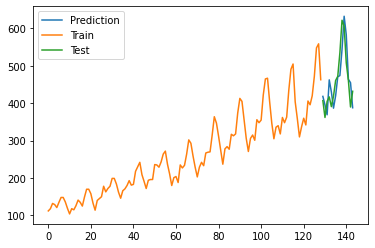

In [20]:
# Do some error analysis
    
errors = np.array(test_data["#Passengers"].values)-np.array(predictions)

print()
print("Mean abs error:",mean_absolute_error(test_data["#Passengers"].values,predictions))
print("Explained variance:",explained_variance_score(test_data["#Passengers"].values,predictions))

predictions = pd.Series(predictions)
predictions.index =test_data.index    

plt.plot(predictions, label="Prediction")

plt.plot(train_data["#Passengers"], label="Train")

plt.plot(test_data["#Passengers"], label="Test")
plt.legend()
plt.show()

## Other ways of time series modeling

### Time Series as multiple regression problem

With appropriate sampling methods we can re-phrase time series problems into regression problems in a more interesting manner, meaning not just taking time as the independent and the target value for dependent variable, but taking using a **window approach** and thus getting back to a multiple regression problem with:

- __X__ matrix containing the elements of the **training time window** and
- __y__ being the next time **step to be predicted**

<img src="https://pcp.io/docs/images/trace_buffer.png" width=400 heigth=400>

- Example 1.: "I have to make a prediction on each Sunday evening"
- Example 2.: "I would like to have a daily forecast"

In this case all the machinery of regression - and thus Scikit's toolbox - is at our disposal.

### Time series classification

But if we accept the constraints of window based approaches - which we, despite our concerns - often do with great success, nothing to prevents us from doing time series classification based on the data structure outlined above, only __y__ being categorical, rather than a numeric value.

In this case, basically we treat **one time step back as one column** and fit a regular classifier on top. 

It is also noteworthy, that this represents a rather "raw" data, thus much of what we have learned by **"representation learning"**, can be applied here. In fact, there are approaches to use PCA like decompositions, either on the raw data (time domain), or it's representation in the frequency domain, like [Singular Spectrum Analysis](https://pyts.readthedocs.io/en/latest/auto_examples/plot_ssa.html). (See more below.)

More on features for time series classification [here](https://medium.com/datadriveninvestor/time-series-classification-using-feature-extraction-16209570a22e) 

As is in case of non-time series data, the appropriate feature engineering is rather important and non-trivial. There are two approaches in this:

#### Automatic feature extraction and selection on time series

In 2014 a [paper](https://arxiv.org/abs/1401.3531) appeared in which the authors argue for an approach where a large number of descriptive features are being automatically generated for the given time series, and later on some will be chosen based on their predictive value. This approach was the foundation for the [hctsa](https://github.com/benfulcher/hctsa) package implemented in MATLAB, with Python accessors.

In 2016 in the same spirit a new pair of results appeared [here](https://arxiv.org/abs/1610.07717) and [here](https://www.researchgate.net/profile/Maximilian_Christ2/publication/324948288_Time_Series_FeatuRe_Extraction_on_basis_of_Scalable_Hypothesis_tests_tsfresh_-_A_Python_package/links/5b0d10710f7e9b1ed7fbf9b9/Time-Series-FeatuRe-Extraction-on-basis-of-Scalable-Hypothesis-tests-tsfresh-A-Python-package.pdf?origin=publication_detail). This laid down the foundation of the highly performant and scalable [tsfresh](https://tsfresh.readthedocs.io/en/latest/) package.

<img src="https://github.com/blue-yonder/tsfresh/raw/master/docs/images/introduction_ts_exa_features.png" width=55%>

The package accepts time series in some given formats, generates **hundreds of features** from the easy to the complicated and then automatically prunes the feature set, keeping only the most predictive ones. With an ensemble based classifier (think RandomForest or XGBoost) it can achieve **highly competitive** results.


#### End-to-end learning

Our goal would be to have such flexible models and learning procedures, that can spare us the burden of manual feature engineering. The main topic of this course will be just about that.



### Classical decomposition methods

It is a "tried and proven" method with a great deal of literature to decompose continuous functions into $sin$ and $cos$ components, which can also be applied to discrete timeseries also, see [Fourier decomposition](https://en.wikipedia.org/wiki/Fourier_analysis).

The main intuition behind it is, that any general function can be approximated by the sum of trigonometric functions.

(It is inside many of the standard decompositions of scientific libraries by default.)

<img src="https://i.stack.imgur.com/27HVo.gif">

[source](https://electronics.stackexchange.com/questions/353253/what-kind-of-signal-processing-circuitry-do-i-need-to-generate-a-line-level-outp?noredirect=1&lq=1)


In [21]:
from IPython.display import HTML


HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/spUNpyF58BY" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')


#### [Periodogram](https://en.wikipedia.org/wiki/Periodogram) in our case

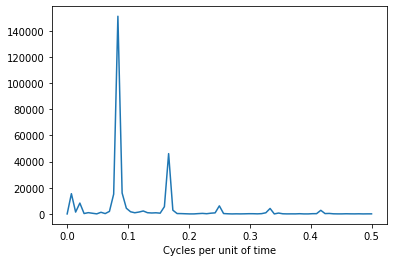

In [22]:
from scipy.signal import periodogram

freq, density = periodogram(reindexed_df["#Passengers"], detrend='linear')
plt.plot(freq, density)
plt.xlabel("Cycles per unit of time")
plt.show()


####  Two drawbacks:

- It is most well suited for periodically repeating signals, where the pattern is repeating ad infinitum
    - A good answer for this challenge can be the usage of ["wavelets"](https://en.wikipedia.org/wiki/Wavelet_transform), which are "signal elements" localized in coordinate space. I this case the choice of appropriate wavelets is the question. 
    <img src="https://www.mathworks.com/content/mathworks/www/en/products/wavelet/jcr:content/feature/items/item_1.adapt.full.high.jpg/1526966636426.jpg">
    
    For Wavelet type models in Python please see [PyWavelets](https://pywavelets.readthedocs.io/en/latest/), and for a good in-depth introduction [here](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)
    
    
- The other challenge is, that fourier methods are best suited for stationary data, it is important to de-trend them
    - Though solutions were presented also for this eg.: [this](https://arxiv.org/abs/1503.06675)
    
    
### Additional resources:

- There are other sophisticated methods for time series prediction, amongs them **[Kálmán filter](https://en.wikipedia.org/wiki/Kalman_filter)**, for an intuitive demonstration see [here](http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)


- Facebook developed a strong set of tools for time series forecasting, that is worth mentioning and experimenting with.
    - The **"Prophet"** tool can be found [here](https://github.com/facebook/prophet) 
    - Corresponding whitepaper [here](https://peerj.com/preprints/3190/)
    - Usage example [here](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a)


- A good and detailed **overview of methods** can be gained from [this](https://arxiv.org/pdf/1503.07493.pdf) paper from 2015.

## Conclusion of time series - for now

Though many methods exist for time series forecasting, some of the typically "nasty" sequences and time series (think for example language as well as eg. financial datasets), especially with **long term dependencies** and **complex, unknown inner structure** do not lend themselves easily for modeling.

The big question will be, how we can use the paradigm of **end-to-end learning for tackling time series problems.**